<a href="https://colab.research.google.com/github/202248SD/5DayGitChallenge/blob/main/Copy_of_TrainClassifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torchvision.models as models
from torchvision import transforms
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch.nn as nn

from glob import glob
import os

from PIL import Image
import matplotlib.pyplot as plt

import random

import time

In [2]:
# Load pre-trained ResNet-50
resnet = models.resnet50(weights='DEFAULT')

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth
100%|██████████| 97.8M/97.8M [00:01<00:00, 72.4MB/s]


In [3]:
# Freeze all layers except the final fully-connected layer for fine-tuning
for param in resnet.parameters():
    param.requires_grad = False

# Replace the final fully-connected layer with a new one (assuming 100 classes)
num_ftrs = resnet.fc.in_features
resnet.fc = torch.nn.Linear(num_ftrs, 120)

In [ ]:
!wget http://vision.stanford.edu/aditya86/ImageNetDogs/images.tar

# Extract the downloaded file
!tar -xvf images.tar

In [5]:
class StanfordDogsDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.classes = sorted(os.listdir(root_dir))
        self.class_to_idx = {cls_name: i for i, cls_name in enumerate(self.classes)}
        self.images = self._make_dataset()

    def _make_dataset(self):
        images = []
        for class_name in self.classes:
            class_dir = os.path.join(self.root_dir, class_name)
            for img_name in os.listdir(class_dir):
                if img_name.endswith('.jpg'):
                    img_path = os.path.join(class_dir, img_name)
                    item = (img_path, self.class_to_idx[class_name])
                    images.append(item)
        return images

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_path, label = self.images[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, label


In [6]:
root_dir = '/content/Images'
transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])


dataset = StanfordDogsDataset(root_dir, transform=transform)

In [7]:
dataloader = DataLoader(dataset, batch_size=32, shuffle=True)

In [8]:
def train_epoch(dataloader, model, loss_fn, optimizer, device):
    model.train()
    size = len(dataloader)
    epoch_loss = []

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Forwardprop
        out = model(X)

        loss = loss_fn(out, y)
        epoch_loss.append(loss.item())

        # Backprop
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss = loss.item()
            print(f"loss: {loss:>7f}  [{batch:>5d}/{size:>5d}]")

    return model, epoch_loss

In [9]:
def plot_loss(total_loss):
  batch_arr = [i+1 for i in range(len(total_loss))]
  plt.plot(batch_arr, total_loss)

  plt.xlabel('Batch no.')
  plt.ylabel('Loss')

  plt.show()

In [10]:
device = ("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu") # set device
print(f"Using device: {device}")

Using device: cuda


In [11]:
model = resnet.to(device)

In [12]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [13]:
epochs = 25 # transfer learning for last layer
total_loss = []
for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")

  epoch_start = time.time()
  model, epoch_loss = train_epoch(dataloader, model, criterion, optimizer, device)
  epoch_end = time.time()

  total_loss.extend(epoch_loss)

  print(f"Epoch time: {epoch_end - epoch_start} seconds")
  print('')

Epoch 1
-------------------------------
loss: 4.792093  [    0/  644]
loss: 4.478464  [  100/  644]
loss: 4.235015  [  200/  644]
loss: 3.899845  [  300/  644]
loss: 3.722217  [  400/  644]
loss: 3.690424  [  500/  644]
loss: 3.456212  [  600/  644]
Epoch time: 171.40681672096252 seconds

Epoch 2
-------------------------------
loss: 3.139540  [    0/  644]
loss: 2.930088  [  100/  644]
loss: 2.931910  [  200/  644]
loss: 2.619374  [  300/  644]
loss: 2.313320  [  400/  644]
loss: 2.347287  [  500/  644]
loss: 2.415914  [  600/  644]
Epoch time: 167.89528942108154 seconds

Epoch 3
-------------------------------
loss: 2.117315  [    0/  644]
loss: 2.245603  [  100/  644]
loss: 1.971990  [  200/  644]
loss: 1.715344  [  300/  644]
loss: 1.819436  [  400/  644]
loss: 1.952984  [  500/  644]
loss: 1.755144  [  600/  644]
Epoch time: 171.07868456840515 seconds

Epoch 4
-------------------------------
loss: 1.379584  [    0/  644]
loss: 1.651527  [  100/  644]
loss: 1.733942  [  200/  644]


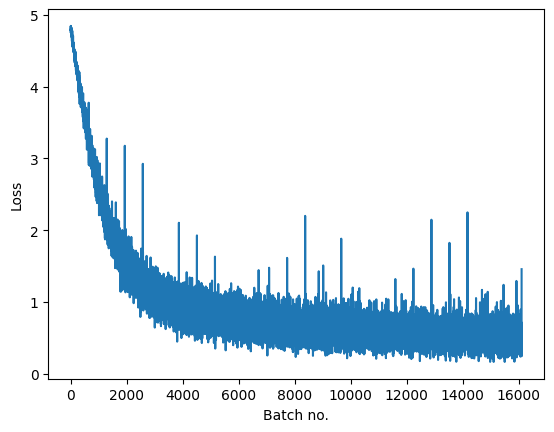

In [14]:
plot_loss(total_loss)

In [15]:
for param in resnet.parameters():
  param.requires_grad = True
optimizer = torch.optim.SGD(model.parameters(), lr=0.0005, momentum=0.9)

In [16]:
epochs = 15  # fine tune all layers
for t in range(epochs):
  print(f"Epoch {t+1}\n-------------------------------")

  epoch_start = time.time()
  model, epoch_loss = train_epoch(dataloader, model, criterion, optimizer, device)
  epoch_end = time.time()

  total_loss.extend(epoch_loss)

  print(f"Epoch time: {epoch_end - epoch_start} seconds")
  print('')

Epoch 1
-------------------------------
loss: 0.585957  [    0/  644]
loss: 0.283501  [  100/  644]
loss: 0.353487  [  200/  644]
loss: 0.159730  [  300/  644]
loss: 0.204333  [  400/  644]
loss: 0.491710  [  500/  644]
loss: 0.255190  [  600/  644]
Epoch time: 202.50896000862122 seconds

Epoch 2
-------------------------------
loss: 0.323496  [    0/  644]
loss: 0.347663  [  100/  644]
loss: 0.250700  [  200/  644]
loss: 0.530459  [  300/  644]
loss: 0.416398  [  400/  644]
loss: 0.464864  [  500/  644]
loss: 0.336425  [  600/  644]
Epoch time: 202.32160139083862 seconds

Epoch 3
-------------------------------
loss: 0.184296  [    0/  644]
loss: 0.177194  [  100/  644]
loss: 0.179906  [  200/  644]
loss: 0.258105  [  300/  644]
loss: 0.342162  [  400/  644]
loss: 0.306546  [  500/  644]
loss: 0.674564  [  600/  644]
Epoch time: 202.70002341270447 seconds

Epoch 4
-------------------------------
loss: 0.156144  [    0/  644]
loss: 0.109130  [  100/  644]
loss: 0.203043  [  200/  644]


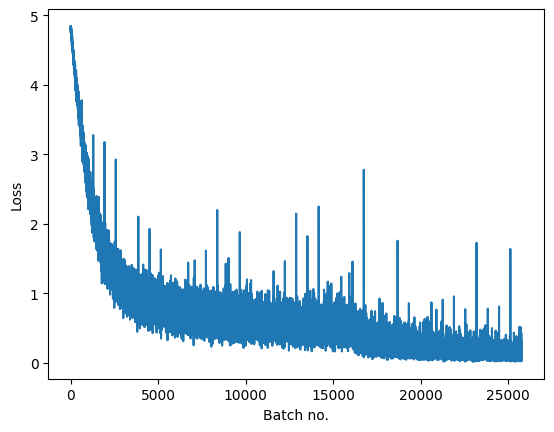

In [17]:
plot_loss(total_loss)

In [18]:
torch.save(model.state_dict(), 'model.pth')

In [20]:
criterion = nn.CrossEntropyLoss()
test_loader = DataLoader(dataset, batch_size=1, shuffle=False)
model.eval()

test_loss = 0.0
correct = 0
total = 0

with torch.no_grad():
    for X, y in test_loader:
        X, y = X.to(device), y.to(device)

        outputs = model(X)

        loss = criterion(outputs, y)

        test_loss += loss.item()

        _, predicted = torch.max(outputs, 1)

        correct += (predicted == y).sum().item()

        total += 1

avg_test_loss = test_loss / total

accuracy = correct / total * 100.0

print(f"Test Loss: {avg_test_loss:.4f}")
print(f"Test Accuracy: {accuracy:.2f}%")

Test Loss: 0.0701
Test Accuracy: 98.32%


In [21]:
print(dataset.class_to_idx)

{'n02085620-Chihuahua': 0, 'n02085782-Japanese_spaniel': 1, 'n02085936-Maltese_dog': 2, 'n02086079-Pekinese': 3, 'n02086240-Shih-Tzu': 4, 'n02086646-Blenheim_spaniel': 5, 'n02086910-papillon': 6, 'n02087046-toy_terrier': 7, 'n02087394-Rhodesian_ridgeback': 8, 'n02088094-Afghan_hound': 9, 'n02088238-basset': 10, 'n02088364-beagle': 11, 'n02088466-bloodhound': 12, 'n02088632-bluetick': 13, 'n02089078-black-and-tan_coonhound': 14, 'n02089867-Walker_hound': 15, 'n02089973-English_foxhound': 16, 'n02090379-redbone': 17, 'n02090622-borzoi': 18, 'n02090721-Irish_wolfhound': 19, 'n02091032-Italian_greyhound': 20, 'n02091134-whippet': 21, 'n02091244-Ibizan_hound': 22, 'n02091467-Norwegian_elkhound': 23, 'n02091635-otterhound': 24, 'n02091831-Saluki': 25, 'n02092002-Scottish_deerhound': 26, 'n02092339-Weimaraner': 27, 'n02093256-Staffordshire_bullterrier': 28, 'n02093428-American_Staffordshire_terrier': 29, 'n02093647-Bedlington_terrier': 30, 'n02093754-Border_terrier': 31, 'n02093859-Kerry_blue

In [22]:
idx_to_class = {i : cls_name[10:] for cls_name, i in dataset.class_to_idx.items()}
print(idx_to_class)

{0: 'Chihuahua', 1: 'Japanese_spaniel', 2: 'Maltese_dog', 3: 'Pekinese', 4: 'Shih-Tzu', 5: 'Blenheim_spaniel', 6: 'papillon', 7: 'toy_terrier', 8: 'Rhodesian_ridgeback', 9: 'Afghan_hound', 10: 'basset', 11: 'beagle', 12: 'bloodhound', 13: 'bluetick', 14: 'black-and-tan_coonhound', 15: 'Walker_hound', 16: 'English_foxhound', 17: 'redbone', 18: 'borzoi', 19: 'Irish_wolfhound', 20: 'Italian_greyhound', 21: 'whippet', 22: 'Ibizan_hound', 23: 'Norwegian_elkhound', 24: 'otterhound', 25: 'Saluki', 26: 'Scottish_deerhound', 27: 'Weimaraner', 28: 'Staffordshire_bullterrier', 29: 'American_Staffordshire_terrier', 30: 'Bedlington_terrier', 31: 'Border_terrier', 32: 'Kerry_blue_terrier', 33: 'Irish_terrier', 34: 'Norfolk_terrier', 35: 'Norwich_terrier', 36: 'Yorkshire_terrier', 37: 'wire-haired_fox_terrier', 38: 'Lakeland_terrier', 39: 'Sealyham_terrier', 40: 'Airedale', 41: 'cairn', 42: 'Australian_terrier', 43: 'Dandie_Dinmont', 44: 'Boston_bull', 45: 'miniature_schnauzer', 46: 'giant_schnauzer'